<a href="https://colab.research.google.com/github/YoonyoungChoi/problem_set/blob/main/STA503_4_%EC%B5%9C%EC%9C%A4%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch
!pip install statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import arch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 902 kB 4.7 MB/s 
     |████████████████████████████████| 9.8 MB 13.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Problem 1** Consider the MA process: $y_t=0.5+0.5e_t+0.3e_{t-1}+0.4e_{t-2}$ where $e_t\sim N(0,1)$. Compute the mean, standard deviation, autocovariance and autocorrelation function of $y_t$.

In [ ]:
# Generation of random number following normal distirbution
error = np.random.randn(1000)

# Initial condition was set to 0
#y_1=0.5+0.5*error_1
#y_2=0.5+0.5*error_1+0.3*error_2

# Run the repetitive statement from y_3
y= [0.5+0.5*error[0], 0.5+0.5*error[1]+0.3*error[0]]
for i in range(len(error)-2):
  y.append(0.5+0.5*error[i+2]+0.3*error[i+1]+0.4*error[i])

In [ ]:
# Mean of y_t
y_mean=np.mean(y)
print(y_mean)

# Standard deviation
def sample_std(x):
  return np.sqrt((np.sum((x-np.mean(x))**2))/(len(x)-1))
print(sample_std(y))

0.49140283070280655
0.7203373720739941


In [ ]:
# Autocovariance
def autocovariance(y, N, order, y_mean):
  autocov = 0
  for i in np.arange(0, N-order):
    autocov += ((y[i+order])-y_mean)*(y[i]-y_mean)
  return (1/(N-1))*autocov

# Autocorrelation
def autocorrelation(y, N, order, y_mean):
  return autocovariance(y, N, order, y_mean)/autocovariance(y, N, 0, y_mean)

In [ ]:
# Set-up the initial condition 
autocov_result=[]
autocor_result=[]

for i in range(100):
  autocov_result.append(autocovariance(y, len(y), i, y_mean))
  autocor_result.append(autocorrelation(y, len(y), i, y_mean))

Hypothesis testing\
$H_0$: sequance $y_t$ is white noise (not MA time series sequence)\
$H_1$: reject $H_0$\
Under $H_0$ condition, all $\theta \geq 0$ and autocovariance k follows normal distirbution $\sim N(0,\frac{1}{N})$, irrelevant to k.\
Standard error = 1/np.sqrt(N)



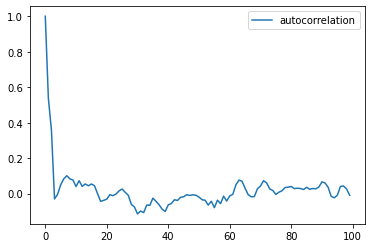

In [ ]:
plt.plot(range(100), autocor_result, label = 'autocorrelation')
plt.xlabel=('order')
plt.ylabel=('value')
plt.legend()

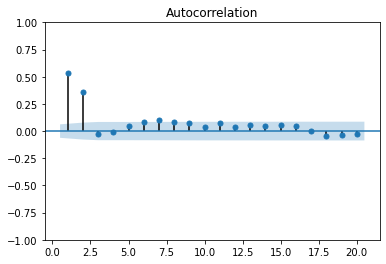

In [ ]:
# Use package statsmodels.graphics.tsaplots
sgt.plot_acf(y, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

**Problem 2** The file abday.txt contains stock returns from Jan. 2, 1990 to Dec. 31, 1999.

In [ ]:
# Import file from local PC ('abday.txt')
from google.colab import files
uploaded = files.upload()
abday = pd.read_csv(io.StringIO(uploaded['abday.txt'].decode('utf-8')),sep = '\t', header = None, encoding = 'utf-8-sig')


Saving abday.txt to abday (3).txt


In [ ]:
display(abday)
abday.columns = ['day', 'return']

,day,return
0,19900102,0.000000
1,19900103,-0.002589
2,19900104,-0.008650
3,19900105,-0.009804
4,19900108,0.004504
...,...,...
2523,19991227,-0.000851
2524,19991228,0.000384
2525,19991229,0.003971
2526,19991230,0.000690


1) Use a 60 day rolling window to compute the standard deviation of daily returns from Sep. 1, 1997 to Dec. 31, 1999. Compute the variance by using an extending window for the mean with all available past data since Jan. 1990, and by assuming the mean is zero. Are they different? Why?

In [ ]:
abday['day']=abday['day'].apply(lambda x : str(x)[0:4]+'-'+str(x)[4:6]+'-'+str(x)[6:8])
abday_part=abday.loc[abday['day']>='1997-09-01']
abday_part['return'].rolling(window=60).std()

1939         NaN
1940         NaN
1941         NaN
1942         NaN
1943         NaN
          ...   
2523    0.010914
2524    0.010913
2525    0.010744
2526    0.010730
2527    0.010515
Name: return, Length: 589, dtype: float64

In [ ]:
abday_var = abday['return'].expanding(1).var()
abday_std = np.sqrt(abday_var)
abday_var[0] = 0

In [ ]:
abday_var_zero = abday['return'] ** 2
abday_var_zero[0] = 0
for i in range(1, len(abday_var_zero)):
    abday_var_zero[i] = np.sum((abday['return'] ** 2)[:i+1]) / i
abday_std_zero = np.sqrt(abday_var_zero)

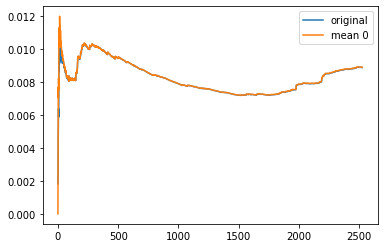

In [ ]:
# Intuition: First, two data shows difference, but as time preceeding the difference decreases
# Therefore, if there is sufficient data point, initial value could be 0
plt.plot(range(len(abday_std)), abday_std, label='original')
plt.plot(range(len(abday_std_zero)),abday_std_zero, label='mean 0')
plt.xlabel=('day')
plt.ylabel=('std')
plt.legend()

2) Now implement a Risk-Metrics estimator with $\lambda=0.96$. You can ignore the mean for this estimator. Compare following two cases. First, compute your first estimate using a 60-day window standard variance estimate on Mar. 1, 1996, and update the estimate. Second, compute your first estimate as the squared returns of Mar. 1, 1996, and update the estimate. How long does it take for these two estimates to become indistinguishable?

In [ ]:
#Risk-Metrics Estimation
lamb=0.96
abday_estimation=abday.copy()
abday_estimation_rolling_var=abday_estimation['return'].rolling(window=60).var()

abday_estimation=pd.DataFrame(list(abday_estimation_rolling_var),columns=['var'])
abday_estimation['day']=abday['day']
abday_estimation['return']=abday['return']
print(abday_estimation)
abday_estimation=abday_estimation.loc[abday_estimation['day']>='1996-03-01']

           var         day    return
0          NaN  1990-01-02  0.000000
1          NaN  1990-01-03 -0.002589
2          NaN  1990-01-04 -0.008650
3          NaN  1990-01-05 -0.009804
4          NaN  1990-01-08  0.004504
...        ...         ...       ...
2523  0.000119  1999-12-27 -0.000851
2524  0.000119  1999-12-28  0.000384
2525  0.000115  1999-12-29  0.003971
2526  0.000115  1999-12-30  0.000690
2527  0.000111  1999-12-31  0.003259

[2528 rows x 3 columns]


In [ ]:
estimate=list(abday_estimation['var'])
for i in range(1,len(estimate)):
  estimate[i]=estimate[i-1]*lamb+(1-lamb)*list(abday_estimation['return']**2)[i]

In [ ]:
estimate_squared=list(abday_estimation['return']**2)
for i in range(1,len(estimate_squared)):
  estimate_squared[i]=estimate_squared[i-1]*lamb+(1-lamb)*estimate_squared[i]


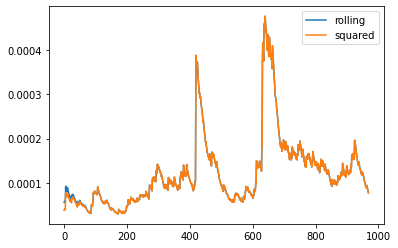

In [ ]:
# Intuition: First, two data shows difference, but as time preceeding the difference decreases
# Therefore, if there is sufficient data point, initial value could be 0
plt.plot(range(len(estimate)),estimate,label='rolling')
plt.plot(range(len(estimate_squared)),estimate_squared,label='squared')
plt.xlabel=('day')
plt.ylabel=('variance')
plt.legend()

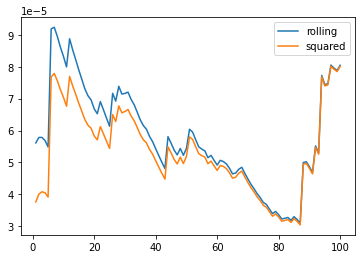

In [ ]:
# After 3 month, the data shows similar pattern
plt.plot(range(1,101),estimate[0:100],label='rolling')
plt.plot(range(1,101),estimate_squared[0:100],label='squared')
plt.xlabel=('day')
plt.ylabel=('variance')
plt.legend()

3) Pick any of the two estimators in 2), and run it until Dec. 31, 1999. Plot the standard rolling window and the RiskMetrics estimators from Jan.1, 1997 to Dec. 31, 1999. Explain the difference, and state which estimator is preferable.

In [ ]:
# General test-rolling data
abday['var']=abday['return'].expanding(1).var()
abday['var'][0]=0
test_rolling=pd.DataFrame(data={'rolling':estimate,
                                'day':abday_estimation['day'],
                                'var':abday_estimation['var']})
test_rolling=test_rolling.loc[test_rolling['day'] >= '1997-01-01']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


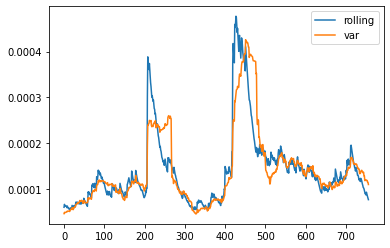

In [ ]:
# Intuition: Why Risk-metrics estimation is more smooth than 60 day rolling var?
# Heteroskedasticity of variance was offseted --> low weight on shock that affect the estimation
# Also, shock was faded-out by lambda
# Shortcut: Not sensitive to change, but 'risk management' value over stability
plt.plot(range(len(test_rolling)),test_rolling['rolling'],label='rolling')
plt.plot(range(len(test_rolling)), test_rolling['var'], label='var')
plt.xlabel=('day')
plt.ylabel=('variance')
plt.legend()

4) (Optional for GARCH maniacs) Find out that the series fits to GARCH (1,1). Confirm that variance is higher when returns are negative. Based on your estimates, forecast the series from Jan. 1, 1997 to Dec. 31, 1999 by GARCH(1,1). How similar is it Risk-Metrics?

In [ ]:
# a standard GARCH(1,1) model
abday_garch=abday.loc[abday['day']>='1997-01-01']

garch=arch.arch_model(abday_garch['return']*100, vol='garch', p=1, o=0, q=1)
garch_fitted=garch.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1172.171409738473
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1171.6890826493566
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1171.6222317502788
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1171.3150881095323
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1171.2682944957453
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1171.0791882605122
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1170.9561770773266
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1170.941008358197
Iteration:      9,   Func. Count:     64,   Neg. LLF: 1170.9398015498796
Iteration:     10,   Func. Count:     70,   Neg. LLF: 1170.9395208013439
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1170.9395208011856
            Iterations: 10
            Function evaluations: 70
            Gradient evaluations: 10


In [ ]:
print(garch_fitted.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1170.94
Distribution:                  Normal   AIC:                           2349.88
Method:            Maximum Likelihood   BIC:                           2368.40
                                        No. Observations:                  757
Date:                Sun, Jun 12 2022   Df Residuals:                      756
Time:                        04:14:05   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1293  4.061e-02      3.184  1.453e-03 [4.971e-0

In [ ]:
# Difference between risk metrics
# Intercept (1): Omega (intercept effect)
# Lambda in risk matrics= beta in GARCH
# alpha = 1-lambda
# (2) Rist metrics suppose lambda + (1-lambda) =1. In GARCH model, alpha+beta could not be 1

**Problem 3** The file abmon.txt contains variance data.

In [ ]:
# Import file from local PC ('abmon.txt')
uploaded = files.upload()
abmon = pd.read_csv(io.StringIO(uploaded['abmon.txt'].decode('utf-8')),delim_whitespace=True,
                    header = None, encoding = 'utf-8-sig')

Saving abmon.txt to abmon (4).txt


In [ ]:
display(abmon)
abmon.columns = ['date', 'var']

,date,var
0,2004-01-01,16.63
1,2004-02-01,14.55
2,2004-03-01,16.74
3,2004-04-01,17.19
4,2004-05-01,15.50
...,...,...
113,2013-06-01,16.86
114,2013-07-01,13.45
115,2013-08-01,17.01
116,2013-09-01,16.60


In [ ]:
abmon.describe()

,var
count,118.000000
mean,20.309068
std,9.222182
min,10.420000
25%,14.235000
50%,17.170000
75%,23.660000
max,59.890000


1) Plot the mean, standard deviation, ACF, and the logarithm of variance.

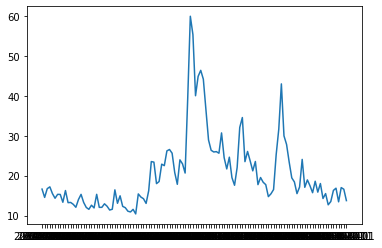

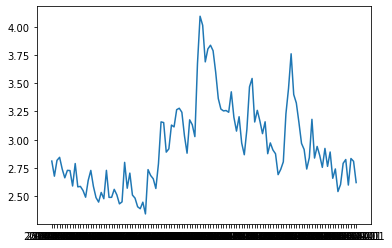

In [ ]:
# Plotting the data --> shows the large variance
plt.plot(abmon['date'],abmon['var'])
plt.show()

# Scaling by log transformation
plt.plot(abmon['date'],np.log(abmon['var']))
plt.show()

2) Now work on log($Variance$). Plot ACF and PACF upto sequence (1:20). Does the variance look stationary? What ARMA(p,q) do you believe is the best model?

In [ ]:
# (optional) Test for nomal time series: Augmented Dickey-Fuller Test
# (Caution: H_0 is abnormal) H_0=abnormal(|rho|=1)/H_1=normal (|rho|<1)
# Result: With log transformation, both are abnormal
result=adfuller(abmon['var'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s : %.3f' % (key, value))

ADF Statistic: -2.481347
p-value: 0.120079
Critical Values:
	1% : -3.489
	5% : -2.887
	10% : -2.580


In [ ]:
#make log
var_log=np.log(abmon['var'])
result=adfuller(var_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.643768
p-value: 0.084284
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


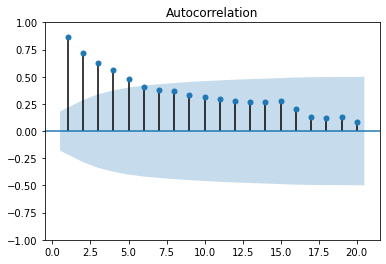

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


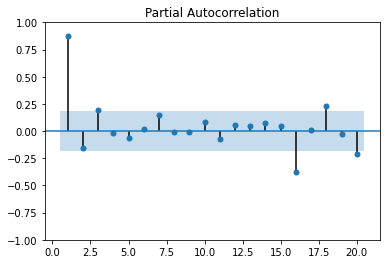

In [ ]:
# ACF, PACF for rawdata
sgt.plot_acf(abmon['var'], lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

sgt.plot_pacf(abmon['var'],lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

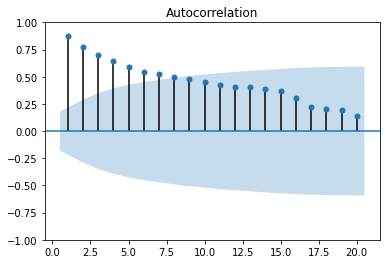

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


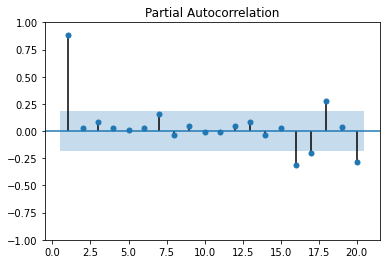

In [ ]:
# ACF, PACF for log transformation data
sgt.plot_acf(np.log(abmon['var']),lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

sgt.plot_pacf(np.log(abmon['var']), lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

High order of AR is inaccurate.\
Why this is happen?--->because it is still abnormal time serises.

3) Now fit AR(1) and AR(2) to the data. Which one fits better?

In [ ]:
# Use raw data, AR(1) is exact and we need to find out whether it is AR(2) or AR(3)
model_ar1=SARIMAX(abmon['var'],order=(1,0,0)) #P,D,Q
model_ar1_fit=model_ar1.fit(trend='c',full_output=True, methods='css-mle',disp=1)
print(model_ar1_fit.summary())
model_ar2=SARIMAX(abmon['var'],order=(2,0,0)) #P,D,Q
model_ar2_fit=model_ar2.fit(trend='c',full_output=True, methods='css-mle',disp=1)
print(model_ar2_fit.summary())
model_ar3=SARIMAX(abmon['var'],order=(3,0,0)) #P,D,Q
model_ar3_fit=model_ar3.fit(trend='c', full_output=True, methods='css-mle', disp=1)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: trend, methods. After release 0.14, this will raise.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: trend, methods. After release 0.14, this will raise.
  FutureWarning


                               SARIMAX Results                                
Dep. Variable:                    var   No. Observations:                  118
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -351.422
Date:                Sun, 12 Jun 2022   AIC                            706.845
Time:                        05:21:39   BIC                            712.386
Sample:                             0   HQIC                           709.095
                                - 118                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9742      0.014     67.633      0.000       0.946       1.002
sigma2        22.0472      1.586     13.902      0.000      18.939      25.156
Ljung-Box (L1) (Q):                   0.59   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: trend, methods. After release 0.14, this will raise.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


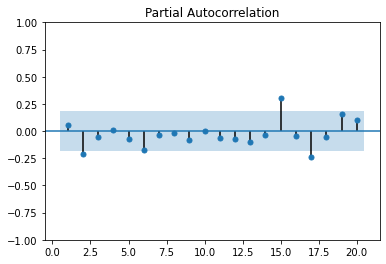

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


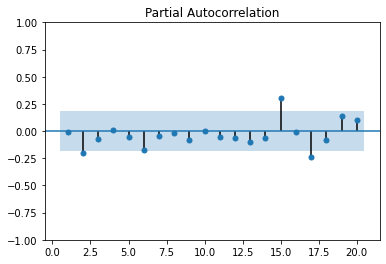

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


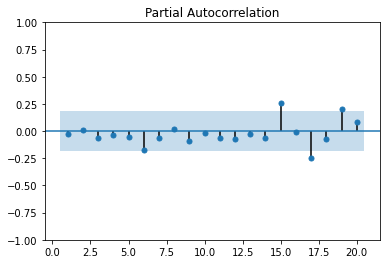

In [ ]:
# AR(1) seem to be best, but the model needs residual test
sgt.plot_pacf(model_ar1_fit.resid, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

sgt.plot_pacf(model_ar2_fit.resid, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

sgt.plot_pacf(model_ar3_fit.resid, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

In [ ]:
# With log transformation
model_ar1=SARIMAX(np.log(abmon['var']),order=(1,0,0)) #P, D, Q
model_ar1_fit=model_ar1.fit(trend='c', full_output=True, methods='css-mle', disp=1)
print(model_ar1_fit.summary())
model_ar2=SARIMAX(np.log(abmon['var']), order=(2,0,0)) #P, D, Q
model_ar2_fit=model_ar2.fit(trend='c', full_output=True, methods='css-mle', disp=1)
print(model_ar2_fit.summary())
model_ar3=SARIMAX(np.log(abmon['var']),order=(3,0,0)) #P,D,Q
model_ar3_fit=model_ar3.fit(trend='c',full_output=True, methods='css-mle', disp=1)
print(model_ar3_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: trend, methods. After release 0.14, this will raise.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: trend, methods. After release 0.14, this will raise.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effec

                               SARIMAX Results                                
Dep. Variable:                    var   No. Observations:                  118
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  29.420
Date:                Sun, 12 Jun 2022   AIC                            -54.840
Time:                        05:40:42   BIC                            -49.299
Sample:                             0   HQIC                           -52.590
                                - 118                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9976      0.006    166.710      0.000       0.986       1.009
sigma2         0.0340      0.004      8.121      0.000       0.026       0.042
Ljung-Box (L1) (Q):                   0.77   Jarque-

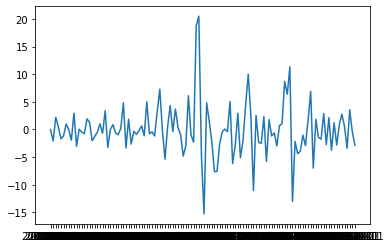

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


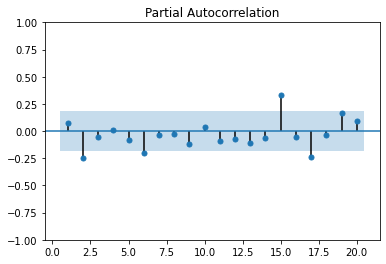

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


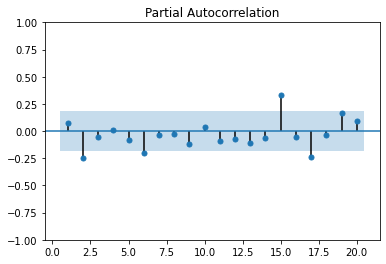

In [ ]:
# ACF, PACF using differential variance
abmon_diff=abmon['var'].diff()
abmon_diff[0]=0

plt.plot(abmon['date'], abmon_diff)
plt.show()

sgt.plot_pacf(abmon_diff, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

sgt.plot_pacf(abmon_diff, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

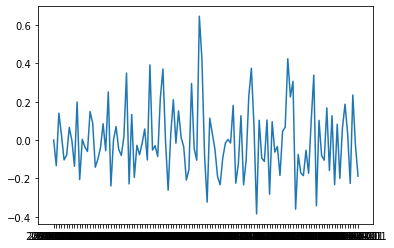

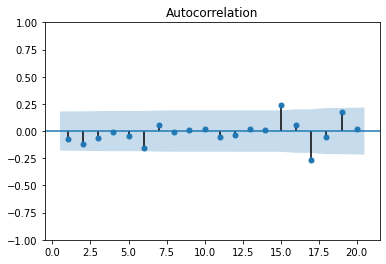

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


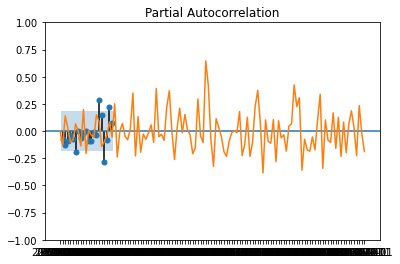

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


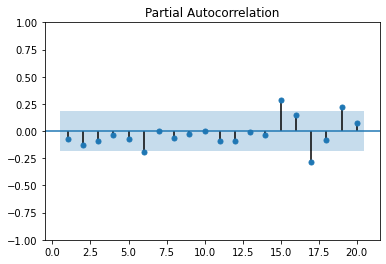

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


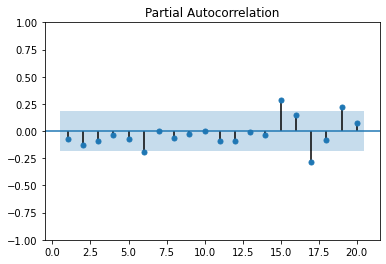

In [ ]:
# The graph shows that middle part needs to be corrected
# log transformation
# Calculation of differential variance after log transformation
abmon_diff_log=np.log(abmon['var']).diff()
abmon_diff_log[0]=0

plt.plot(abmon['date'], abmon_diff_log)
plt.show()

# ACF, PACF for differential variance
sgt.plot_acf(abmon_diff_log, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

sgt.plot_pacf(abmon_diff_log, lags=20, zero=False)
plt.xticks=(range(1,21))

# Calculating differential variance after log transformation
abmon_diff_log=np.log(abmon['var']).diff()
abmon_diff_log[0]=0

plt.plot(abmon['date'],abmon_diff_log)
plt.show()

# ACF,PACF for differential variance
sgt.plot_pacf(abmon_diff_log, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

sgt.plot_pacf(abmon_diff_log, lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()


In [ ]:
# ARIMA(0,1,0) model after log transformation
# Test to find out whether this time series data is white noise--> Ljung-Box Test

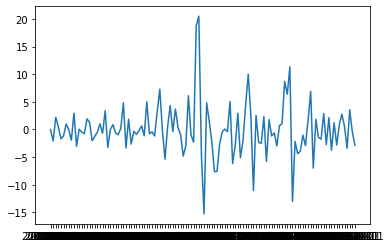

In [ ]:
# Correcting the middle part of the graph (shows the atypical pattern)
abmon_diff = abmon['var'].diff()
abmon_diff[0]=0

plt.plot(abmon['date'], abmon_diff)
plt.show()

In [ ]:
# additive outlier : middle part of the graph that shows the large variance considered to be one-shot outlier
#How? dummy variable regression > ARIMA by residual (large variance: 1, otherwise: 0)

4) (Optional for forecasting maniac) Apply your model to out-of-sample-data. Cut your data into a half for training and the other half for testing. What happens if you do the same prediction for the raw (un-logged values) data? What's the benefit of logarithm?\

In [ ]:
# After Forecating, dummy variable regression, set-up ARIMA model by using residuals
# Time series Decomposition